# Interpretability and Explainability | Grad-CAM

This tutorial demonstrates how to use the **gradient-weighted class activation mapping (Grad-CAM)** [1] to visualize the CNN's saliency map for the skin lesion classification task on the [ISIC 2019](https://challenge.isic-archive.com/data/#2019) dataset. 

<!-- Use this command to show the figure if you are offline. -->
<!-- ![Demo Figure](Util/demo1_1.jpg) -->

<img src="https://github.com/siyi-wind/TAIMI_trustworthy/raw/main/Util/demo1_1.jpg" alt="Alt text" width="500">

Grad-CAM uses the gradients of any target concept flowing into the final convolutional layer to produce a coarse localization map.

In this tutorial, we will cover the following topics

- Load a pre-trained CNN

- Forward pass a skin image to get the predicted class

- Grad-CAM

    -  Define Grad-CAM

    - Apply Grad-CAM to generate a saliency map

    - Visualize Grad-CAM

<br>

**Note**: To use Google Colab's GPU, click 'Runtime' --> 'Change runtime type' -->  'T4 GPU'

[1] Selvaraju, Ramprasaath R., et al. "Grad-CAM: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE international conference on computer vision. 2017.

### Step 1: Import Libraries
To run the code on your own computer, please first install [Miniconda](https://docs.anaconda.com/miniconda/install/) and then run the following command to create a virtual environment and install the required packages. 
```python
conda env create --file trustworthy_env.yaml
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

/home/siyi/miniconda3/envs/selfsuper/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# # TODO If you use Google Colab, uncomment the following code
# from google.colab import drive
# drive.mount('/content/gdrive')

# # Change to the path of the tutorial
# import os
# path = './gdrive/MyDrive/Code/ic/TAIMI_trustworthy' 
# os.chdir(path)

### Step 2: Load a Pretrained Model and an Input Image 
Here we utilize a ResNet-18 [1] that has been pre-trained on skin images.

[1] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.


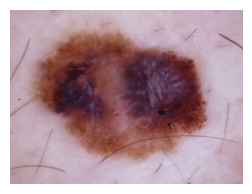

In [3]:
# Load a pretrained model
model = models.resnet18()
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load("Checkpoint/ISIC2019_model.pth"))

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    tensor = preprocess(image).unsqueeze(0)
    return tensor, image

image_path = "Data/ISIC2019/images/ISIC_0035900.jpg"  # Replace with your image path
input_tensor, original_image = load_and_preprocess_image(image_path)

# Visualize the original image
plt.figure(figsize=(3, 3))
plt.imshow(original_image)
plt.axis("off")
plt.show()

### Step 3: Forward Pass and Get Prediction
Forward pass the image through our model to get a classification prediction. The ground-truth label for the ISIC_0035900 image is 1.  

In [4]:
# Forward pass through the model
model.eval()
output = model(input_tensor)
output = F.softmax(output, dim=1)
predicted_class = torch.argmax(output, dim=1).item()
print(f"Predicted class index: {predicted_class}")

Predicted class index: 1


### Step 4: Define Grad-CAM

<!-- Use this command to show the figure if you are offline. -->
<!-- ![Demo Figure](Util/demo1_2.jpg) -->

<img src="https://github.com/siyi-wind/TAIMI_trustworthy/raw/main/Util/demo1_2.jpg" alt="Alt text" width="600">

To obtain the class-discriminative localization map Grad-CAM $L^c_{Grad-CAM}$ for any class $c$, we need to

1. Calculate the neuron importance weights $\delta_k^c$ of $k$-th feature map $A^k$
$$
\delta_k^c = \overset{\text{global average pooling}}{\overbrace{\frac{1}{Z}\sum_i\sum_j}} \underset{\text{gradients via back propagation}}{\underbrace{\frac{\partial y^c}{\partial A^k_{ij}}}} \tag{1}
$$

2. Perform a weighted combination of forward activation maps, and follow it by a ReLU
$$
L^c_{Grad-CAM} = \operatorname{ReLU} \underset{\text{linear combination}}{\underbrace{(\sum_k \delta^c_k A^k)}} \tag{2}
$$

In [5]:
class GradCAM:
    # Initialize the GradCAM class
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.hook_layers()

    # Register hooks to record the gradients and activations
    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    # Generate the Grad-CAM
    def generate(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)

        # Backward pass
        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()

        # Compute Grad-CAM
        # Eq (1)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        # Eq (2)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)

        # Normalize the CAM
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.detach().cpu().numpy()

### Step 5: Apply Grad-CAM

In [6]:
# Select the target layer and initialize Grad-CAM
target_layer = model.layer4[-1].conv2  # Example target layer, the final convolutional layer
grad_cam = GradCAM(model, target_layer)

# Generate Grad-CAM
cam = grad_cam.generate(input_tensor, predicted_class)

### Step 6: Visualize the results

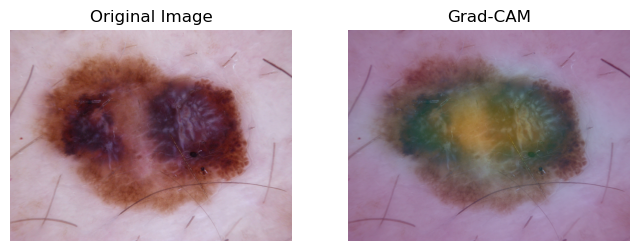

In [7]:
def overlay_heatmap_on_image(heatmap, original_image, alpha=0.6, colormap="viridis"):
    # Resize heatmap to match original image
    heatmap = np.uint8(heatmap * 255)
    heatmap_resized = Image.fromarray(heatmap).resize(original_image.size, resample=Image.Resampling.BICUBIC)

    # Apply colormap
    colormap = plt.get_cmap(colormap)
    colored_heatmap = colormap(np.array(heatmap_resized) / 255.0)[:, :, :3]  # Remove alpha channel

    # Overlay heatmap on the image
    overlay = alpha * colored_heatmap + (1 - alpha) * np.array(original_image) / 255
    return np.uint8(255 * overlay)


# Display the results     
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

overlayed_image = overlay_heatmap_on_image(cam, original_image)

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(original_image)
plt.imshow(overlayed_image, cmap='jet', alpha=0.5)  # Overlay the heatmap
plt.axis('off')
plt.show()